In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2 as cv
import pandas as pd
import random
import ntpath

In [84]:
# getting the data from git and formatting it
data_dir = 'C:/CVT/Projects/Behavorial_Cloning/Data' # path of the original data which is git
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

C:\Users\kenil\AppData\Local\Temp\ipykernel_69548\1551281683.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


center  \
0  C:\CVT\Projects\Behavorial_Cloning\Data\IMG\center_2023_02_14_16_05_13_493.jpg   
1  C:\CVT\Projects\Behavorial_Cloning\Data\IMG\center_2023_02_14_16_05_13_594.jpg   
2  C:\CVT\Projects\Behavorial_Cloning\Data\IMG\center_2023_02_14_16_05_13_696.jpg   
3  C:\CVT\Projects\Behavorial_Cloning\Data\IMG\center_2023_02_14_16_05_13_796.jpg   
4  C:\CVT\Projects\Behavorial_Cloning\Data\IMG\center_2023_02_14_16_05_13_897.jpg   

                                                                            left  \
0   C:\CVT\Projects\Behavorial_Cloning\Data\IMG\left_2023_02_14_16_05_13_493.jpg   
1   C:\CVT\Projects\Behavorial_Cloning\Data\IMG\left_2023_02_14_16_05_13_594.jpg   
2   C:\CVT\Projects\Behavorial_Cloning\Data\IMG\left_2023_02_14_16_05_13_696.jpg   
3   C:\CVT\Projects\Behavorial_Cloning\Data\IMG\left_2023_02_14_16_05_13_796.jpg   
4   C:\CVT\Projects\Behavorial_Cloning\Data\IMG\left_2023_02_14_16_05_13_897.jpg   

                                                                            right  \
0   C:\CVT\Projects\Behavorial_Cloning\Data\IMG\right_2023_02_14_16_05_13_493.jpg   
1   C:\CVT\Projects\Behavorial_Cloning\Data\IMG\right_2023_02_14_16_05_13_594.jpg   
2   C:\CVT\Projects\Behavorial_Cloning\Data\IMG\right_2023_02_14_16_05_13_696.jpg   
3   C:\CVT\Projects\Behavorial_Cloning\Data\IMG\right_2023_02_14_16_05_13_796.jpg   
4   C:\CVT\Projects\Behavorial_Cloning\Data\IMG\right_2023_02_14_16_05_13_897.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000081  
1  0.0       0.0       0.0      0.000078  
2  0.0       0.0       0.0      0.000080  
3  0.0       0.0       0.0      0.000081  
4  0.0       0.0       0.0      0.000080

In [85]:
# truncating the path to only image itself which is the tail end
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

center                              left  \
0  center_2023_02_14_16_05_13_493.jpg  left_2023_02_14_16_05_13_493.jpg   
1  center_2023_02_14_16_05_13_594.jpg  left_2023_02_14_16_05_13_594.jpg   
2  center_2023_02_14_16_05_13_696.jpg  left_2023_02_14_16_05_13_696.jpg   
3  center_2023_02_14_16_05_13_796.jpg  left_2023_02_14_16_05_13_796.jpg   
4  center_2023_02_14_16_05_13_897.jpg  left_2023_02_14_16_05_13_897.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2023_02_14_16_05_13_493.jpg  0.0       0.0       0.0      0.000081  
1  right_2023_02_14_16_05_13_594.jpg  0.0       0.0       0.0      0.000078  
2  right_2023_02_14_16_05_13_696.jpg  0.0       0.0       0.0      0.000080  
3  right_2023_02_14_16_05_13_796.jpg  0.0       0.0       0.0      0.000081  
4  right_2023_02_14_16_05_13_897.jpg  0.0       0.0       0.0      0.000080

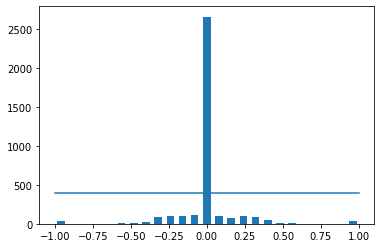

In [86]:
# visualize the steering angles for each camera angle
num_bins = 25

samples_per_bin = 400 # defining a threshold to remove samples above that for e.g in 0 degrees

hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5 # to get center as zero
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin)) # ((x1,x2),(y1,y2))

Total data:  3634
Removed data:  2257
Remaining data:  1377


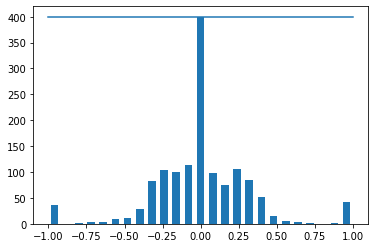

In [87]:
# removing the excess data as data is skewed towards middle the model would be biased to driving straight
print('Total data: ', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]: # values are stored in lower index bin
            list_.append(i)
    list_ = shuffle(list_) # indexes are ordered so shuffling to get all parts of the track
    list_ = list_[samples_per_bin:] # the segment of the list which needs to be removed (above threshold)
    remove_list.extend(list_) # 'extend'appends the values at end of list

print('Removed data: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True) # remove data from original set by the index value from remove list
print('Remaining data: ', len(data))

hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))



In [88]:
print(data.iloc[100])
print(len(data))
# creating the dataset with images as input and labels as steering value which is output
def load_img_steering(data_dir, data):
    image_path = []
    steering_path = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(data_dir, center)) # getting the path of images according to the filtered data
        steering_path.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path) # converting list into array
    steering_paths = np.asarray(steering_path)
    return image_paths, steering_paths

image_paths, steering_paths = load_img_steering(data_dir + '/IMG', data) # adding /IMG to reference the image paths

center      center_2023_02_14_16_05_42_274.jpg
left        left_2023_02_14_16_05_42_274.jpg  
right       right_2023_02_14_16_05_42_274.jpg 
steering   -0.30512                           
throttle    1.0                               
reverse     0.0                               
speed       30.1674                           
Name: 285, dtype: object
1377


In [89]:
# splitting the test train data

X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_paths, test_size = 0.2, random_state=6) 
print(f'Training samples: {len(X_train)} \nValid samples: {len(X_valid)}')

Training samples: 1101 
Valid samples: 276


Text(0.5, 1.0, 'Validation set')

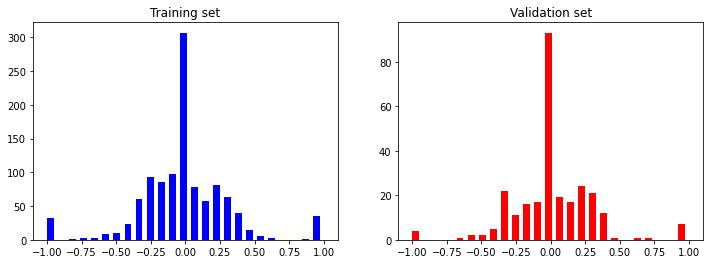

In [90]:
# visualizing steering angles in test and train data set

fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train, num_bins,width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, num_bins,width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

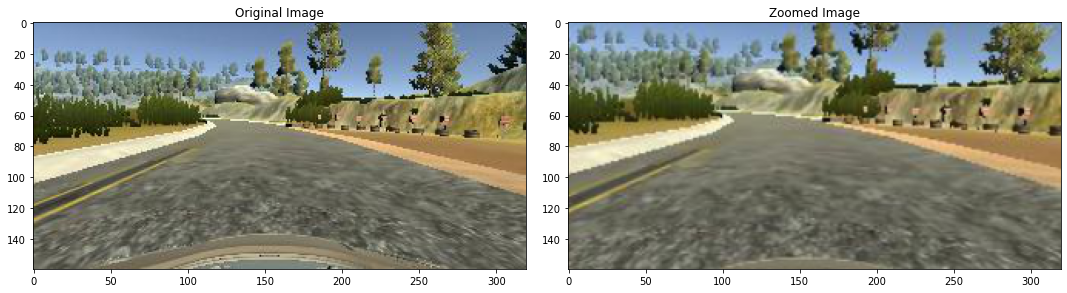

In [91]:
# data augmentation 
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')


Text(0.5, 1.0, 'Panned Image')

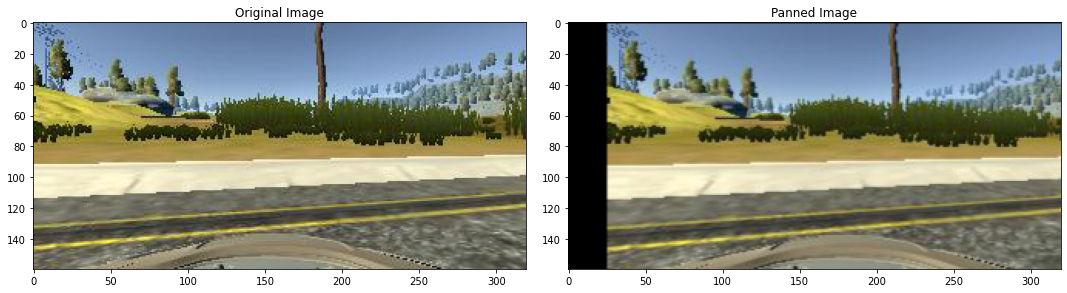

In [92]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness altered image ')

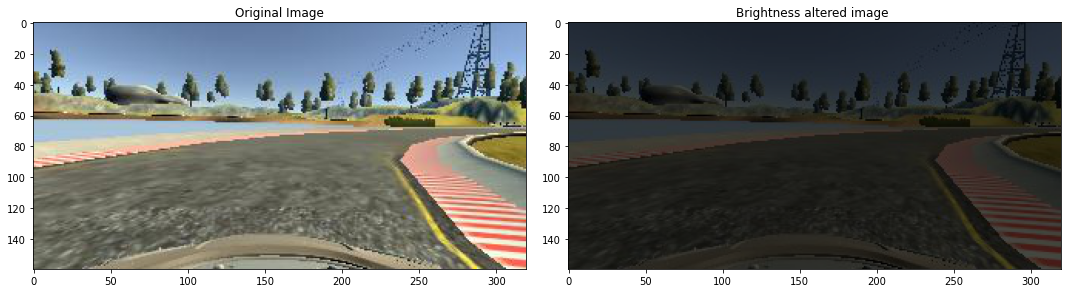

In [94]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle: -0.3290313')

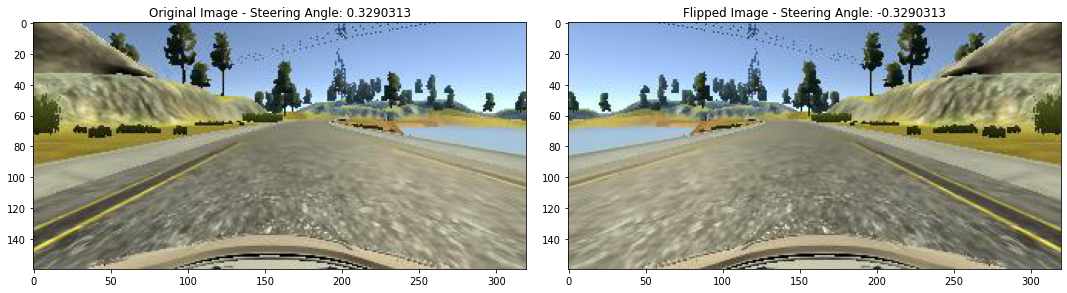

In [95]:
def img_random_flip(image, steering_angle):
    image = cv.flip(image,1) # 1 for horizontal flip
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steering_paths[random_index]
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle: ' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle: ' + str(flipped_steering_angle))

In [96]:
# applying random augmentation
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
  
    return image, steering_angle

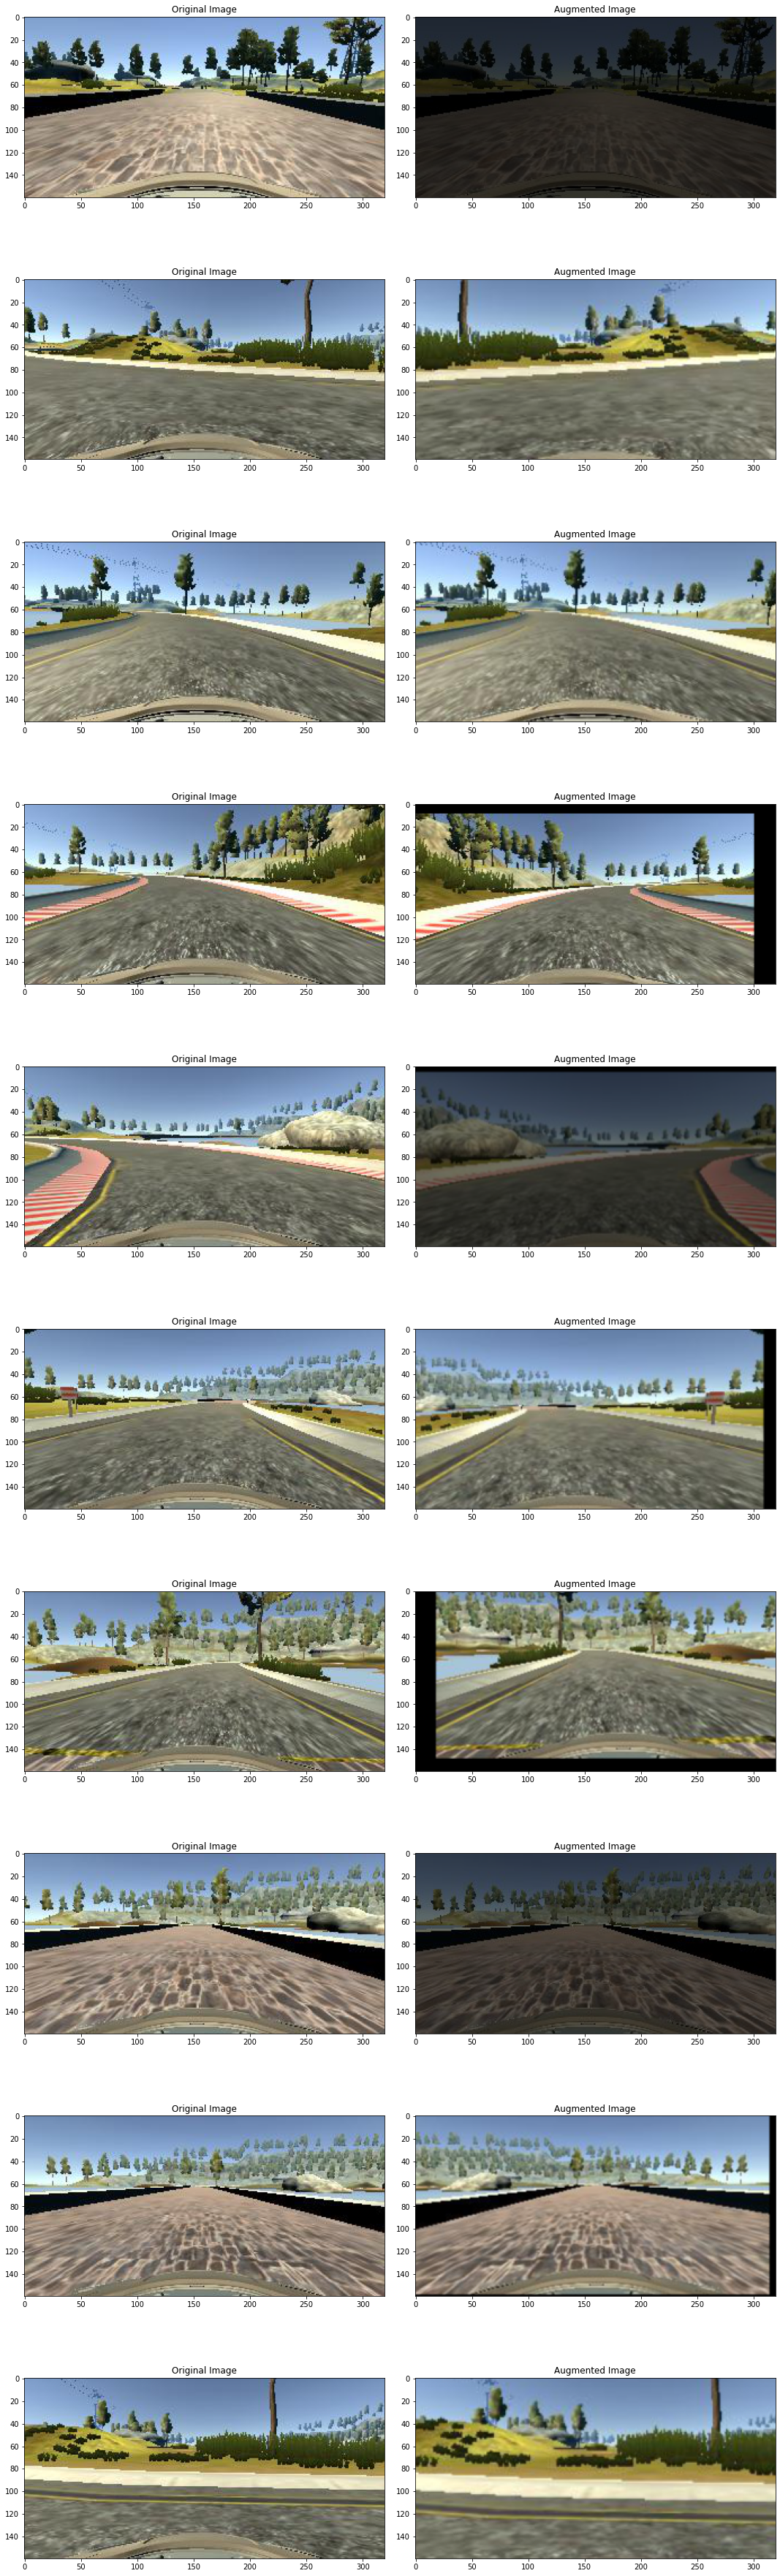

In [97]:
# displaying the random augmentation
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steering_paths[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
  
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [98]:
# preprocessing the data - filtering the images

# just calling img will call its path, so using imread to store actual image from path
def img_preprocess(img): 
    #img = mpimg.imread(img) #not required as it is already mentioned in batch generator function
    img = img[60:135,:,:] # cutting image [h,w,channels]
    img = cv.cvtColor(img, cv.COLOR_RGB2YUV) # YUV is recommended for NVIDIA model
    img = cv.GaussianBlur(img, (3,3), 0)
    img = cv.resize(img, (200,66))
    img = img/255 # normalizing the image
    return img

Text(0.5, 1.0, 'Preprocessed Image')

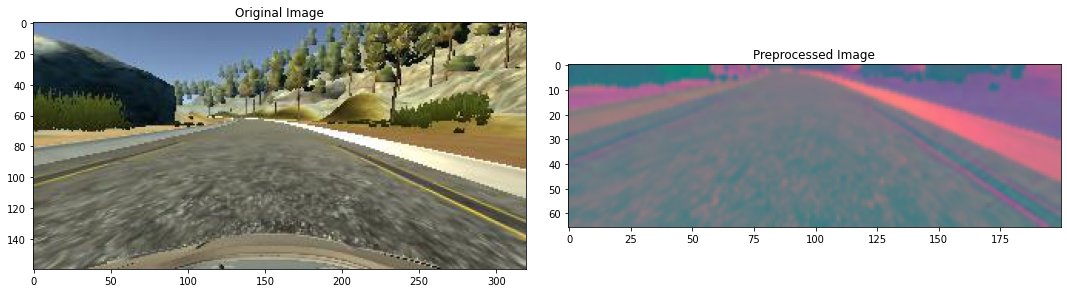

In [99]:
# visualizing the original and preprocessed image
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = mpimg.imread(image)
preprocessed_image = img_preprocess(preprocessed_image)

fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')


In [100]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
      
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))  

Text(0.5, 1.0, 'Validation Image')

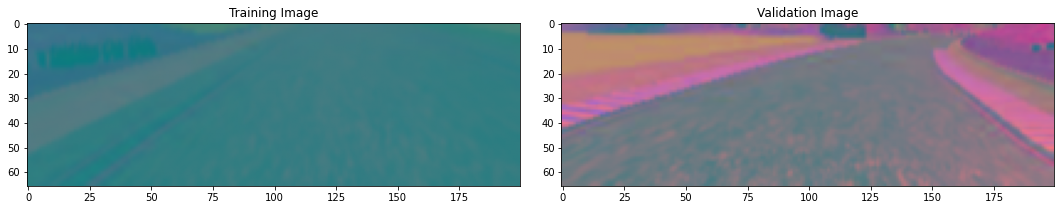

In [104]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [105]:
# X_train = np.array(list(map(img_preprocess, X_train))) # maps the function to entire dataset and returns as list. Then convert to array.
# X_valid = np.array(list(map(img_preprocess, X_valid)))

In [107]:
# plt.imshow(X_train[2])
# print(X_train.shape)

In [108]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))

  
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
  
  
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))
  
  
    optimizer= Adam(learning_rate=1e-4)
    model.compile(loss='mse', optimizer=optimizer)
  
    return model

In [109]:
model = nvidia_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_8 (Dense)             (None, 100)              

In [110]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=50,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

C:\Users\kenil\AppData\Local\Temp\ipykernel_69548\4101018817.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/50
300/300 [==============================] - 114s 381ms/step - loss: 0.0855 - val_loss: 0.0528
Epoch 2/50
300/300 [==============================] - 113s 377ms/step - loss: 0.0770 - val_loss: 0.0462
Epoch 3/50
300/300 [==============================] - 113s 379ms/step - loss: 0.0702 - val_loss: 0.0406
Epoch 4/50
300/300 [==============================] - 113s 378ms/step - loss: 0.0603 - val_loss: 0.0352
Epoch 5/50
300/300 [==============================] - 112s 375ms/step - loss: 0.0556 - val_loss: 0.0333
Epoch 6/50
300/300 [==============================] - 113s 377ms/step - loss: 0.0492 - val_loss: 0.0372
Epoch 7/50
300/300 [==============================] - 112s 376ms/step - loss: 0.0441 - val_loss: 0.0296
Epoch 8/50
300/300 [==============================] - 113s 376ms/step - loss: 0.0426 - val_loss: 0.0292
Epoch 9/50
300/300 [==============================] - 113s 378ms/step - loss: 0.0391 - val_loss: 0.0296
Epoch 10/50
300/300 [==============================] - 113s 378m

Text(0.5, 0, 'Epoch')

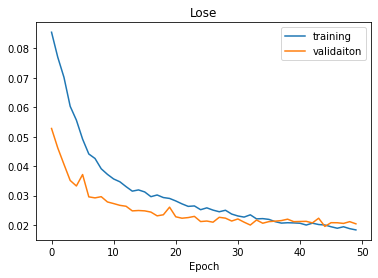

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validaiton'])
plt.title('Lose')
plt.xlabel('Epoch')

In [112]:
model.save('model.h5')

In [27]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>